# Homework 8

## PHYS 2600

__Important notice:__ All cells in your notebook will be run, start to finish, using a fresh kernel when it is graded! To make sure the graded notebook looks like what you expect, we recommend selecting "Runtime > Restart session and run all" from the menu above in Colab before you finish.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

If you worked collaboratively on this assignment, __include the names of your collaborators in the cell below:__

## 8.0 - Homework correction (3 points)

In the cell below, explain and correct __one mistake__ you made on homework #6.  If you got a perfect score, great, tell us what your favorite problem was, or use the space to give any other feedback you might have on the class/tutorials/homework.

## 8.1 - Hitting the mark with air resistance (41 points)

_(Note: __this is the only problem on this week's homework!__  Think of this as a miniature version of the projects that you'll be doing at the end of the semester.  You should start early to make sure you have time to chat with other students if you get stuck...)_

We've done a number of kinematics problems, but most of them didn't include anything you didn't already know the answer to.  Now that we can solve ODEs, we can go far beyond what pen and paper can do!

Let's consider __two-dimensional kinematics with air resistance.__ For relatively small speeds (and/or small objects), the effect of air resistance is to give a _drag_ force which is proportional to the speed:

$$
\mathbf{F}_{\rm drag} = -b\mathbf{v}
$$

For larger objects and higher speeds, a _quadratic_ drag force becomes important,

$$
\mathbf{F}_{\rm drag, quad} = - cv\mathbf{v}
$$

(where $c$ itself depends on some things like [air density and the size of our object](http://hyperphysics.phy-astr.gsu.edu/hbase/airfri.html), but we'll just assume those are all fixed.)  The units of $b$ are kg/s, and for $c$ we have kg/m.

If we add in gravity as well, the two-dimensional kinematic equations are, split into x- and y-components,

$$
m \frac{d^2x}{dt^2} = -bv_x -  c v_x \sqrt{v_x^2 + v_y^2} \\
m \frac{d^2y}{dt^2} = -mg - bv_y -  c v_y \sqrt{v_x^2 + v_y^2}
$$

### Part A (12 points)

To solve this as an initial-value problem using our ODE methods, we need to split this into _four first-order ODEs_ for the quantities $x$, $v_x$, $y$ and $v_y$.  That's easy enough to do:

$$
\frac{dx}{dt} = v_x \\
\frac{dy}{dt} = v_y \\
\frac{dv_x}{dt} = -bv_x - cv_x \sqrt{v_x^2 + v_y^2} \\
\frac{dv_y}{dt} = -mg - bv_y - cv_y \sqrt{v_x^2 + v_y^2} 
$$

Following the procedure described in lecture, we now convert to finite-difference equations by using the first-order forward discrete derivative assuming we've made everything into a discrete set of samples $t_i, x_i, y_i...$, with a fixed grid spacing $\Delta t$ between our points in time.

For example, we replace

$$
\frac{dx}{dt} \rightarrow \frac{x_{i+1} - x_i}{\Delta t}
$$

which converts the first equation above into

$$
x_{i+1} = x_i + v_{x,i} \Delta t 
$$

__In the Markdown cell below, write out the other three finite-difference equations using TeX math:__

$$
y_{i+1} = ? \\
v_{x,i+1} = ? \\
v_{y,i+1} = ?
$$

(Remember, you can double-click on this cell to copy the Markdown source for those equations; then fill out the right-hand sides.  Notice the `\\`, which in TeX notation at the end of a line means "start a new equation line after this".)

Discretizing the $dy/dt$ equation gives basically the same equation as the one for $x_{i+1}$:

$$
y_{i+1} = y_i + v_{y,i} \Delta t
$$

The other two equations are more complicated, but it's not any harder to discretize!  For example, once we convert

$$
\frac{dv_x}{dt} \rightarrow \frac{v_{x,i+1} - v_{x,i}}{\Delta t}
$$

then we just reorganize the equation to get

$$
v_{x,i+1} = v_{x,i} - \Delta t (b v_{x,i} + cv_{x,i} \sqrt{v_{x,i}^2 + v_{y,i}^2})
$$

and similarly,

$$
v_{y,i+1} = v_{y,i} - \Delta t (mg + b v_{y,i} + cv_{y,i} \sqrt{v_{x,i}^2 + v_{y,i}^2})
$$

### Part B (15 points)

Now that we have equations, we can use the __forward Euler method__ to solve them, as we did in previous tutorials:

* Evaluate the right-hand side of the difference equations at step $i$;
* Store the results as the value of each variable at step $i+1$;
* Repeat for the next step, until we reach the end of the trajectory.

For simplicity, we'll fix $g = 9.8\ m/s^2$ and $m = 1$ kg, and the motion will always start from $(x_0, y_0) = (0,0)$.

__Implement the function `solve_motion(t, b, c, v_0)` below__, which should solve the kinematic equations you wrote down in part A taking the following inputs:

* `b` and `c`, the drag coefficients appearing above;
* `t`, a discrete list of time values over which we'll be solving the equation.  (For example, if we want to solve the motion for 5 seconds using 200 steps, we would call `solve_motion` with `t=np.linspace(0,5,200)`.)
*  `v_0` is a length-two tuple containing the initial conditions for speed in both x and y, in the form `v_0 = (v_x0, v_y0)`.

The function __should return two arrays `x` and `y`__ which contain the results for the trajectory at each timestep, $x_i$ and $y_i$.

I didn't give you a docstring or comments to guide you this time; __maybe you should write your own before you start!__ (If you get stuck, you should _definitely_ write out what you're trying to do in comments and docstring.)

(__Hint:__ if you get stuck planning out the function `solve_motion`, try to follow what we did on tutorial 13: write a separate function `compute_next_step(x, y, vx, vy, dt)` that returns `(next_x, next_y, next_vx, next_vy)`, and then incorporate that into your big function `solve_motion`.)

In [2]:
def solve_motion(t, v_0, b, c):
    """
    Args:
        t: 1D array of time values.
        v_0: Tuple (v_x0, v_y0) giving the initial velocity components at t[0].
        b: Linear drag coefficient, used in the force term -b*v.
        c: Quadratic drag coefficient, used in the force term -c*|v|*v.

    Returns:
        (x, y): Two 1D NumPy arrays, same shape as `t`, containing the x- and y-positions
        at each time step.
    """

    g = 9.8  # m/s^2
    m = 1  # kg

    ### BEGIN SOLUTION
    # Find dt and N
    dt = t[1] - t[0]
    Nt = len(t)

    # Initialize arrays for our trajectory
    x = np.zeros_like(t)
    y = np.zeros_like(t)
    vx = np.zeros_like(t)
    vy = np.zeros_like(t)

    # Set initial values
    vx[0], vy[0] = v_0

    # Iterate and apply the Euler step
    for i in range(0, Nt - 1):
        x[i + 1] = x[i] + vx[i] * dt
        y[i + 1] = y[i] + vy[i] * dt

        speed_i = np.sqrt(vx[i] ** 2 + vy[i] ** 2)

        vx[i + 1] = vx[i] + dt * (-b * vx[i] - c * vx[i] * speed_i)
        vy[i + 1] = vy[i] + dt * (-m * g - b * vy[i] - c * vy[i] * speed_i)

    return x, y

    ### END SOLUTION

There are a couple of simple tests that you can run to make sure things are working correctly in your solver above:

* If you set both `b` and `c` to zero, you should get regular motion with no drag.  In particular, remember that the range of a projectile fired from the origin with no drag is:

$$
R = \frac{v_0^2 \sin (2\theta)}{g} 
$$

* If `c` is zero but `b` is not, then the motion [can be solved analytically](http://farside.ph.utexas.edu/teaching/336k/Newtonhtml/node29.html) _(be aware: the link uses different notation than we do!)_.  In particular, in the limit that `b` is very large, the range becomes

$$
R = \frac{m v_0 \cos \theta}{b}
$$

If we set the initial speed to $(v_x, v_y) = (3,3)$ m/s, then $v_0 = 3\sqrt{2} = 4.243$ m/s.  Plugging in numbers, we can find

$$
R = 1.837\ \rm{m}\ \ \textrm{(no drag)} \\
R = 0.100\ \rm{m}\ \ (\textrm{extreme drag}, b = 30\ \rm{kg/s})
$$

Make sure your numerical solution gets both of these right!  I've given you a range-finding function below that takes x,y trajectories as `solve_motion` should return them.

In [3]:
# Range-finder for trajectories (x(t), y(t)).
# Note that this will have a numerical error depending on dt.
# If your answer looks wrong, first try adding more steps!


def find_range(x, y):

    # Cut off the first few entries, since y starts
    # at exactly zero and we don't want to find x=0!
    i_zero = np.abs(y[3:]).argmin()
    i_zero += 3  # i_zero is off by 3 since we cut off y; fix it!

    return x[i_zero]

In the cell below, check your code by __calculating the motion for `b=0`, `c=0`__ over a time range of 5 seconds.  __Plot the trajectory__ and make sure it looks reasonable.  Then in the next cell, __use `find_range` to check the range__ against the formula above.

(You may write an automatic test with `assert` or `numpy.testing.assert_allclose`, or you can check the range by hand.  But show your work either way!)

(0.0, 0.5)

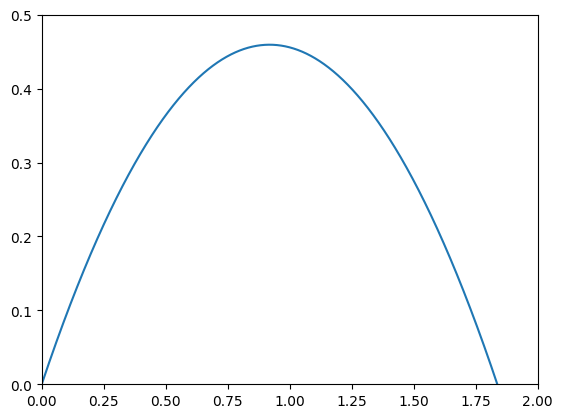

In [4]:
# Check/plot your solver for b=0, c=0 here

### BEGIN SOLUTION
t = np.linspace(0, 5, 40000)
x, y = solve_motion(t, (3, 3), b=0, c=0.0)

plt.plot(x, y)
plt.xlim(0, 2)
plt.ylim(0, 0.5)
### END SOLUTION

In [5]:
# Test the range against the analytic result here!
known_R = 1.837

### BEGIN SOLUTION
print("Range =", find_range(x, y))
### END SOLUTION

Range = 1.8371709292732317


Now, air resistance!  In the cell below, check your code by __calculating the motion for `b=30` kg/s, `c=0`__ over a time range of 5 seconds.  __Plot the trajectory__ and make sure it looks reasonable.  Then in the next cell, __use `find_range` to check the range__ against the formula above.

(You may write an automatic test with `assert` or `numpy.testing.assert_allclose`, or you can check the range by hand.  But show your work either way!)

Range = 0.099996285358153


(0.0, 0.1)

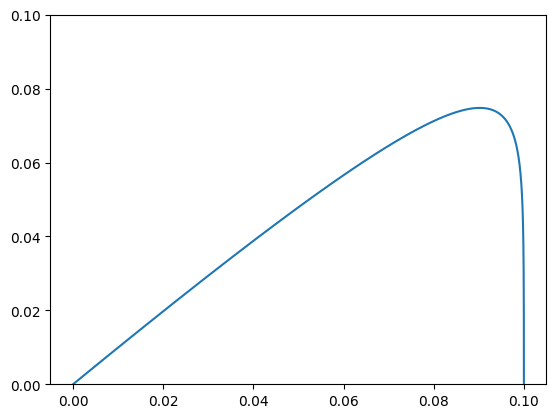

In [6]:
# Check/plot your solution for b=30 kg/s, c=0  here

### BEGIN SOLUTION
x, y = solve_motion(t, (3, 3), b=30, c=0)
print("Range =", find_range(x, y))

plt.plot(x, y)
plt.ylim(0, 0.1)
### END SOLUTION

In [7]:
# Test the range against the analytic result here!
known_R = 0.100

### BEGIN SOLUTION
print("Range =", find_range(x, y))
### END SOLUTION

Range = 0.099996285358153


In [8]:
# testing cell
import numpy.testing as npt

t = np.linspace(0, 5, 20000)
x1, y1 = solve_motion(t, (3, 3), b=0, c=0)
x2, y2 = solve_motion(t, (3, 3), b=30, c=0)

print("x1[0:10] = ", x1[0:10])
print("y1[0:10] = ", y1[0:10])
print("x2[0:10] = ", x2[0:10])
print("y2[0:10] = ", y2[0:10])

npt.assert_allclose(x1[y1 >= 0][-1], 1.837, atol=1e-3)
npt.assert_allclose(x2[y2 >= 0][-1], 0.100, atol=1e-3)

npt.assert_allclose(y1[1000], 0.444, atol=1e-3)
npt.assert_allclose(y2[1000], 0.029, atol=1e-3)

x1[0:10] =  [0.         0.00075004 0.00150008 0.00225011 0.00300015 0.00375019
 0.00450023 0.00525026 0.0060003  0.00675034]
y1[0:10] =  [0.         0.00075004 0.00149946 0.00224827 0.00299647 0.00374406
 0.00449104 0.0052374  0.00598315 0.00672829]
x2[0:10] =  [0.         0.00075004 0.00149445 0.00223328 0.00296657 0.00369435
 0.00441668 0.00513359 0.00584513 0.00655132]
y2[0:10] =  [0.         0.00075004 0.00149384 0.00223144 0.00296291 0.00368827
 0.00440758 0.00512089 0.00582823 0.00652965]


### Part C (14 points)

Now, the grand finale.  You are given a projectile with drag coefficients $b = 0.7$ kg/s and $c = 0.2$ kg/m; the mass is still 1 kg as we've assumed before.  __There are two targets:__ 

* Target 1 is on the ground at $(x,y) = (3,0)$;
* Target 2 is at $(x,y) = (2,2)$.
<!-- * Target 2 is at $(x,y) = (0.5,1)$; -->

Adjusting both the initial speed and angle, there are an _infinite_ number of solutions to this problem!  So let's simplify by saying __the initial launch speed is 12 m/s__.  Assume the targets have __zero width and height__: you must hit the exact coordinates above as closely as possible.  Also, ignore collisions, i.e. you don't have to worry about whether your shot hits a different target than the one you're aiming at.

__Find the launch angles $\theta_1, \theta_2$ (in radians) needed to hit each of the two targets:__ save your answers in the variables `theta_1`, `theta_2` below.  Your answers will be checked to within _three digits of accuracy after the decimal._

There are no tests for this problem, and no guidelines; all you need to do is hit the targets.  (The only rule is that you must _show your work_ and your code here has to find the angles, i.e. you can't use some other program to solve this and just plug in the numerical values below.)

_(Hint: you should recognize this as a boundary-value problem.  In fact, since we're literally shooting at targets, this seems like an ideal candidate for shooting!)_

_(Another hint: just making plots of where the projectile goes for various choices of the angle is probably a good place to start!)_



__Tricky things you should watch out for:__

1. Now we're evolving in _time_, but our boundary exists in _position_.  So we don't know before starting how many seconds we need to calculate for!  Make sure your `t`-range is long enough that it isn't messing up your shooting solver...

2. Checking the boundary is trickier than for the Schrodinger equation: first we need to find the timestep where our solution for `x` crosses `x_target`, and _then_ we can check how far `y` is from `y_target`.  How can you find the timestep?  Well, this sounds very similar to what I did up in `find_range` above, where we found the timestep where the difference between `y` and 0 was smallest...

3. There are _two_ values of $\theta$ that will hit each of the targets; either solution is fine, although some of them are a little trickier to find and may require a good initial guess.

4. Since there are often two solutions, a bisection root-finder is hard to use here.  The `scipy.optimize.newton` finder worked well for me, but __the default options for `newton` will probably lead to frustration!__ You probably want to adjust both the tolerance option `tol=...` and the maximum number of iterations `maxiter=...`.


(If you manage to find __all four solutions__ for `theta` that will hit the targets, then you will get up to _4 points of bonus credit back_ for any mistakes you made elsewhere on this homework!  You can't do better than a perfect score, though.)

In [9]:
from scipy.optimize import newton

### BEGIN SOLUTION


def solution_shoot_projectile(
    target, theta_0=np.pi / 4, b=0.7, c=0.2, v0=12, tmax=10, points_per_sec=1000
):
    """
    Find the launch angle theta that will hit a target,
    given drag coefficients b,c and initial speed v0.

    Uses shooting to solve the BVP, like our Schrodinger equation solution
    on tutorial 16.
    """

    t = np.linspace(0, tmax, tmax * points_per_sec)

    def delta_target(theta):
        v0_theta = (v0 * np.cos(theta), v0 * np.sin(theta))
        xt, yt = solve_motion(t, v0_theta, b=b, c=c)

        # Find the closest x to the target...
        i_target = np.abs(xt - target[0]).argmin()

        # ...and see how far off the y-coordinate is.
        return yt[i_target] - target[1]

    # Now use a root-finder on theta
    theta_opt = newton(delta_target, theta_0, tol=1e-5, maxiter=200)
    xopt, yopt = solve_motion(
        t, (v0 * np.cos(theta_opt), v0 * np.sin(theta_opt)), b=b, c=c
    )

    return (xopt, yopt), theta_opt


### END SOLUTION

0.19847922800440995 0.9520896281681404 1.0621189339900587 1.182853125110048


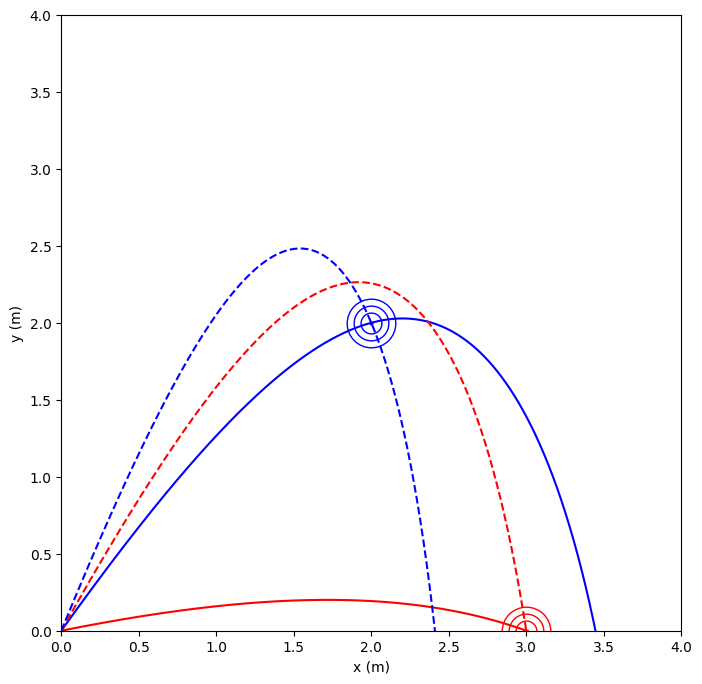

In [10]:
# Save your launch angle solutions in these variables - overwrite them below!
theta_1 = np.pi / 4
theta_2 = np.pi / 4


# Draw the targets
plt.figure(figsize=(8, 8))


def plot_target(x, y, color):
    plt.plot(x, y, color=color, marker="o", markersize=2)
    plt.plot(x, y, color=color, marker="o", markersize=15, fillstyle="none")
    plt.plot(x, y, color=color, marker="o", markersize=25, fillstyle="none")
    plt.plot(x, y, color=color, marker="o", markersize=35, fillstyle="none")


plot_target(3, 0, color="red")  # Target 1 - hit this with launch angle theta_1
plot_target(2, 2, color="blue")  # Target 3 (--> theta_2)

plt.xlim(0, 4)
plt.ylim(0, 4)
plt.xlabel("x (m)")
plt.ylabel("y (m)")

# Now plot your solutions to see if they look reasonable!


### BEGIN SOLUTION
(x1, y1), theta_1 = solution_shoot_projectile((3, 0))
(x2, y2), theta_2 = solution_shoot_projectile((2, 2))

# Alternative shot for target 1
(x1a, y1a), theta_1a = solution_shoot_projectile((3, 0), theta_0=1.05)

# Alternative shot for target 2
(x2a, y2a), theta_2a = solution_shoot_projectile((2, 2), theta_0=np.pi / 2 - 0.3)

plt.plot(x1, y1, color="red")
plt.plot(x2, y2, color="blue")
plt.plot(x1a, y1a, color="red", linestyle="--")
plt.plot(x2a, y2a, color="blue", linestyle="--")

print(theta_1, theta_2, theta_1a, theta_2a)

### END SOLUTION

In [11]:
# testing cell

# Your answers should be saved in these variables!!
# You will lose credit if they aren't!
print(f"{theta_1=:.3f}, {theta_2=:.3f}")

check_1 = np.abs(theta_1 - 0.198479) <= 1e-3
check_1a = np.abs(theta_1 - 1.062109) <= 1e-3
check_2 = np.abs(theta_2 - 0.952090) <= 1e-3
check_2a = np.abs(theta_2 - 1.182853) <= 1e-3

assert check_1 or check_1a
assert check_2 or check_2a

## theta tests to be added here

theta_1=0.198, theta_2=0.952


-----

### Extra material 

(This stuff is _not_ part of the assignment, just for your information.)

The `find_range` function I gave you above is sort of naive, since it just returns the nearest x-coordinate to the y-value that's nearest zero.  We could imagine improving this by __linear interpolation__: find a pair of (x,y) values bracketing zero, and then draw a line between them.  This makes the function significantly more complicated:

In [12]:
def find_range_interp(x, y):
    # Start with brute-force root finding, NumPy style!
    # Find the timestep i where y is closest to zero.
    # (The particle _starts_ at zero, so throw out the first
    # few points in the path to avoid confusion.)
    i_zero = np.abs(y[5:]).argmin() + 5

    # Figure out which way zero is from y[i_zero].
    # Then do a linear interpolation to estimate the zero crossing.
    if y[i_zero - 1] / y[i_zero] < 0:
        # Sign changed to the left of i_zero
        i1 = i_zero - 1
        i2 = i_zero
    elif y[i_zero + 1] / y[i_zero] < 0:
        # Sign changed to the right of i_zero
        i1 = i_zero
        i2 = i_zero + 1
    else:
        # This should never happen if we understand our own algorithm!
        # Make sure the program crashes if we somehow end up in this branch.
        assert False

    # If y = mx + b, then y=0 at x=-b/m.
    m = (y[i2] - y[i1]) / (x[i2] - x[i1])
    b = y[i1] - m * x[i1]

    return -b / m

If you try this above where we used `find_range`, you'll find that it doesn't really help with needing a lot of points to get the range correct!  This is because although we have reduced one source of discretization error with `find_range_interp`, this source of error is _small_ compared to the accumulated error from integrating the entire trajectory using Euler's method!

(If we used a more sophisticated scheme like Runge-Kutta 4-5, then `find_range_interp` might have been more useful to use.)